In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import _pickle as cPickle

## https://www.cs.toronto.edu/~kriz/cifar.html, this is the link to the dataset

In [2]:
# got the below code snippet from the above website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
CIFAR_DIR = 'cifar-10-batches-py/'

In [4]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [5]:
#define a list to copy the data in the subsequent steps
all_data = [0,1,2,3,4,5,6]

In [6]:
for i,direc in zip(all_data, dirs):
    all_data[i] = unpickle(CIFAR_DIR + direc)

In [7]:
#copy the data in all_data[i] to different variables, so that its easy to process 
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [8]:
#print (batch_meta)
batch_meta
#gives a dictionary with the keys as: label names, num_cases_for_batch, number of dimensions

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [9]:
print (batch_meta.keys())

dict_keys([b'label_names', b'num_vis', b'num_cases_per_batch'])


In [10]:
print (data_batch1.keys())

dict_keys([b'data', b'labels', b'filenames', b'batch_label'])


In [11]:
#Grab a single image from one of the batches and Display that image
# 
X = data_batch1[b'data'] # b is important
print("The size of the data_batch1 Matrix is",X.shape)

The size of the data_batch1 Matrix is (10000, 3072)


In [12]:
#Reshape the image so that its size is: 32*32, since its a color image, 
# we keep the 3 channels (RGB)
X = X.reshape(10000,3,32,32)#.transpose(0,2,3,1).astype("uint8")
print ("The reshaped Matrix is of the size",X[0].shape)
# transpose the matrix, since the imshow command accepts commands in the form of (Height, Width, Channels)
X = X.transpose(0,2,3,1).astype("uint8")

The reshaped Matrix is of the size (3, 32, 32)


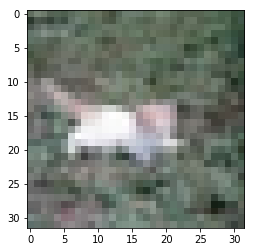

In [13]:
# Display any one image from batch_1
plt.imshow(X[39])

In [14]:
# Manipulate the data for ease of processing
def one_hot(vector, values = 10):
    n = len(vector)
    out = np.zeros((n, values))
    print (out)
    range(n)
    out[range(n),vector] = 1
    return out
#one_hot([1,2,3,4,5,6,7,8,8,9,1], 10)

In [15]:
class Helper_functions():
    def __init__(self):
        self.i = 0
        #grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # grab a list of the one test batch
        self.test_batch = [test_batch]
        # Initialize empty variables for later use
        self.training_images = None
        self.training_labels = None
        self.test_images = None
        self.test_labels = None
        
    def set_up_images(self):
        print("setting training images and labels")
        #vertically stacks the training images
        self.training_images = np.vstack(d[b"data"] for d in self.all_train_batches)
        train_len = len(self.training_images)
        
        #reshape and normalize the training images
        self.training_images = self.training_images.reshape(train_len, 3,32,32).transpose(0,2,3,1)/255
        # one hot encodes the training labels 
        self.training_labels = one_hot(np.hstack([d[b"labels"] for d in self.all_train_batches]),10)
        
        print ("setting up test images and labels")
        #vertically stacks the testing images
        self.test_images = np.vstack(d[b"data"] for d in self.test_batch)
        test_len = len(self.test_images)
        
        #reshape and normalize the training images
        self.test_images = self.test_images.reshape(test_len, 3,32,32).transpose(0,2,3,1)/255
        # one hot encodes the training labels 
        self.test_labels = one_hot(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        #Assuimg a batch size of 100
        x = self.training_images[self.i : self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i : self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y
    


In [16]:
ch = Helper_functions()
ch.set_up_images()
# to get the next batch use
batch = ch.next_batch(100)

setting training images and labels
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
setting up test images and labels
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


# creating the CNN Model

In [17]:
# create two placeholders x and y_true as usual
x = tf.placeholder(tf.float32, shape = [None, 32,32,3])
y_true = tf.placeholder(tf.float32, shape = [None, 10])

#create one more placeholder, hold_probability. 
#There is no need of shape here, this placeholder will hold a single probability of the dropout.
hold_prob = tf.placeholder(tf.float32)

In [18]:
# Helper functions
# 1. initialize the weights
# 2. initialize the bias
# 3. conv2d
# 4. max_pool_2by2
# 5. convolutional layer
# 6. normal_full_layer

def init_weights(shape):
    init_random_dist  = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W,strides=[1,1,1,1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [19]:
# create the layers
# First convolutional layer
convo_1 = convolutional_layer(x, shape = [4,4,3,32])
# pooling layer
convo_1_pooling = max_pool_2by2(convo_1)

In [20]:
# create the next convolutional layers
convo_2 = convolutional_layer(convo_1_pooling, shape = [4,4,32,64])
convo_2_pooling  = max_pool_2by2(convo_2)

In [21]:
# convo_2 to flat
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 8*8*64])

In [22]:
# create  a new full layer using the normal_full_layer function
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [23]:
# create the dropout layer
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [24]:
y_pred = normal_full_layer(full_one_dropout, 10)

In [25]:
#Loss Function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits=y_pred))

In [26]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [ ]:
# Create a variable to initialize all global tf variables
init = tf.global_variables_initializer()

In [ ]:
# Graph session
with tf.Session() as sess:
    sess.run(init)
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x:batch[0], y_true:batch[1], hold_prob:0.5})
        
        if i%100 == 0:
            print ("STEP: {}".format(i))
            matches = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            print(sess.run(acc, feed_dict={x:ch.test_images, y_true:ch.test_labels, hold_prob:1.0}))
            print('\n')

STEP: 0
